In [6]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

from pathlib import Path
import json
import pickle
import numpy as np
import torch as T
import torch.nn as nn
import matplotlib.pyplot as plt
from src.models.decision_transformer import DecisionTransformer
from src.evaluation.evaluate import evaluate_model_batched


In [7]:
# Set up device
device = T.device('cuda' if T.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def set_seed(seed):
    np.random.seed(seed)
    T.manual_seed(seed)
    if T.cuda.is_available():
        T.cuda.manual_seed_all(seed)
set_seed(42)

Using device: cuda


# Experimentos de return conditioning

Este notebook explora cómo el Decision Transformer responde a diferentes condiciones de recompensa objetivo (`target_return`).

Objetivos y pasos:

- Cargar el modelo entrenado y los usuarios de prueba (`test_users`) junto con las trayectorias de entrenamiento.
- Calcular percentiles representativos del `returns_to_go` inicial en las trayectorias de entrenamiento (p25, p50, p75, p90, max) y usarlos como valores de `target_return` a evaluar.
- Evaluar el modelo usando `evaluate_model_batched` para cada `target_return` y registrar métricas clave: `HR@k`, `NDCG@k` y `MRR`.
- Visualizar cómo varía, por ejemplo, `HR@10` en función del `target_return` y realizar una evaluación por `user_group` (análisis por cluster) para identificar comportamientos diferenciados entre grupos.

Notas:
- `evaluate_model_batched` realiza la inferencia en batches y aplica el condicionamiento por `target_return` antes de generar recomendaciones (ver implementación en `src/evaluation/evaluate.py`).
- Comparar percentiles permite observar si pedir recompensas más altas cambia la calidad o el orden de las recomendaciones (posible trade-off entre precisión y objetivo de retorno).

In [8]:
# Rutas
test_path = "../data/test_users/netflix8_test.json"

final_model_path = "../results/trained_models/trained_model.pt"
reference_model_path = "../reference_code/trained_model_reference.pt"

# Cargar usuarios de test
with open(test_path, "r") as f:
    test_users = json.load(f)
    
# Cargar trayectorias de entrenamiento normalizadas
train_trajectories_path = "../data/processed/trajectories_train.pkl"
with open(train_trajectories_path, "rb") as f:
    train_trajectories = pickle.load(f)

In [9]:
num_items = 752
num_groups = 8
# hidden_dim = 512
hidden_dim = 256
n_layers = 2
n_heads = 4
context_length = 25
max_timesteps = 200
dropout = 0.1
batch_size = 64
num_epochs = 2000
learning_rate = 0.0001

final_model = DecisionTransformer(
    num_items=752,
    num_groups=8,
    hidden_dim=hidden_dim,
    n_layers=n_layers,
    n_heads=n_heads,
    context_length=context_length,
    max_timestep=max_timesteps,
    dropout=dropout
).to('cuda')

# Cargar pesos entrenados
ckpt_path = Path(final_model_path) 
state_dict = T.load(ckpt_path, map_location=device)
final_model.load_state_dict(state_dict) 

# Preparar para inferencia
final_model.to(device)
final_model.eval()

print("Modelo cargado desde:", ckpt_path)

final_model_metrics = evaluate_model_batched(
    model=final_model,
    test_data=test_users,
    device=device,
    target_return=None,
    k_list=(5, 10, 20),
    context_len=20,
    eval_batch_size=1024,
)

C:\Users\SudokuX\AppData\Local\Temp\ipykernel_24028\4088997379.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = T.load(ckpt_path, map_location=device)


Modelo cargado desde: ..\results\trained_models\trained_model.pt


Percentiles:
  p25: 213.00
  p50: 350.00
  p75: 497.00
  p90: 604.00
  max: 849.00

Usando sample_size=200, n_bootstrap=30 para estimar incertidumbre.

Evaluando con target_return = p25 (R=213.00)...
  HR@10   = 0.0157 ± 0.0001 (bootstrap n=30, sample_size=200)
  NDCG@10 = 0.0072 ± 0.0000
  MRR     = 0.0103 ± 0.0000

Evaluando con target_return = p50 (R=350.00)...
  HR@10   = 0.0154 ± 0.0000 (bootstrap n=30, sample_size=200)
  NDCG@10 = 0.0071 ± 0.0000
  MRR     = 0.0103 ± 0.0000

Evaluando con target_return = p75 (R=497.00)...
  HR@10   = 0.0154 ± 0.0000 (bootstrap n=30, sample_size=200)
  NDCG@10 = 0.0070 ± 0.0000
  MRR     = 0.0103 ± 0.0000

Evaluando con target_return = p90 (R=604.00)...
  HR@10   = 0.0153 ± 0.0000 (bootstrap n=30, sample_size=200)
  NDCG@10 = 0.0070 ± 0.0000
  MRR     = 0.0103 ± 0.0000

Evaluando con target_return = max (R=849.00)...
  HR@10   = 0.0153 ± 0.0000 (bootstrap n=30, sample_size=200)
  NDCG@10 = 0.0070 ± 0.0000
  MRR     = 0.0103 ± 0.0000


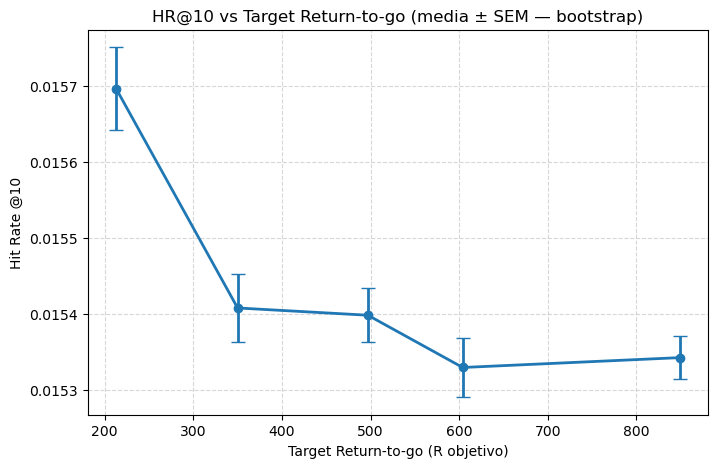

In [10]:
# Experimentos con valores de return to go (muestreo bootstrap para acelerar)
trajectories = train_trajectories
test_data = test_users

# calcular percentiles de returns en training con numpy
train_returns = [traj['returns_to_go'][0] for traj in trajectories]

percentiles = {
    'p25': np.percentile(train_returns, 25),
    'p50': np.percentile(train_returns, 50),
    'p75': np.percentile(train_returns, 75),
    'p90': np.percentile(train_returns, 90),
    'max': np.max(train_returns)
}

print("Percentiles:")
for name, value in percentiles.items():
    print(f"  {name}: {value:.2f}")

results = {}

# Parámetros para acelerar la evaluación
sample_size = min(200, len(test_data))   # número de usuarios por muestra
n_bootstrap = 30                       
rng = np.random.default_rng(42)

print(f"\nUsando sample_size={sample_size}, n_bootstrap={n_bootstrap} para estimar incertidumbre.")

# Para cada target_return hacemos n_bootstrap evaluaciones sobre muestras aleatorias (con reemplazo)
for name, rtg_value in percentiles.items():
    print(f"\nEvaluando con target_return = {name} (R={rtg_value:.2f})...")
    hr_boot = []
    ndcg_boot = []
    mrr_boot = []

    for b in range(n_bootstrap):
        # muestreo con reemplazo de usuarios
        idxs = rng.integers(0, len(test_data), size=sample_size)
        sample_users = [test_data[i] for i in idxs]

        metrics = evaluate_model_batched(
            model=final_model,
            test_data=sample_users,
            device=device,
            target_return=rtg_value,
            k_list=(5, 10, 20),
            context_len=20,
            eval_batch_size=256,  # reduce el overhead de llamadas
        )

        if metrics is None:
            # En caso de fallo, registramos NaNs para mantener la longitud
            hr_boot.append(np.nan)
            ndcg_boot.append(np.nan)
            mrr_boot.append(np.nan)
            continue

        hr_boot.append(metrics.get('HR@10', np.nan))
        ndcg_boot.append(metrics.get('NDCG@10', np.nan))
        mrr_boot.append(metrics.get('MRR', np.nan))

    # convertir a arrays y limpiar NaNs
    hr_arr = np.array(hr_boot, dtype=np.float64)
    ndcg_arr = np.array(ndcg_boot, dtype=np.float64)
    mrr_arr = np.array(mrr_boot, dtype=np.float64)

    hr_arr = hr_arr[~np.isnan(hr_arr)]
    ndcg_arr = ndcg_arr[~np.isnan(ndcg_arr)]
    mrr_arr = mrr_arr[~np.isnan(mrr_arr)]

    def mean_sem_from_boot(arr):
        if arr.size == 0:
            return (np.nan, np.nan)
        mean = arr.mean()
        sem = arr.std(ddof=1) / np.sqrt(arr.size) if arr.size > 1 else 0.0
        return mean, sem

    hr_mean, hr_sem = mean_sem_from_boot(hr_arr)
    ndcg_mean, ndcg_sem = mean_sem_from_boot(ndcg_arr)
    mrr_mean, mrr_sem = mean_sem_from_boot(mrr_arr)

    results[name] = {
        'HR@10_mean': hr_mean,
        'HR@10_sem': hr_sem,
        'NDCG@10_mean': ndcg_mean,
        'NDCG@10_sem': ndcg_sem,
        'MRR_mean': mrr_mean,
        'MRR_sem': mrr_sem,
        'n_sample': int(sample_size),
        'n_bootstrap': int(hr_arr.size)
    }

    print(f"  HR@10   = {hr_mean:.4f} ± {hr_sem:.4f} (bootstrap n={results[name]['n_bootstrap']}, sample_size={sample_size})")
    print(f"  NDCG@10 = {ndcg_mean:.4f} ± {ndcg_sem:.4f}")
    print(f"  MRR     = {mrr_mean:.4f} ± {mrr_sem:.4f}")

# Graficar Return objetivo vs HR@10 con barras de error (SEM)
rtg_values = [v for v in percentiles.values()]
hr10_means = [results[k]['HR@10_mean'] for k in percentiles.keys()]
hr10_sems = [results[k]['HR@10_sem'] for k in percentiles.keys()]

plt.figure(figsize=(8, 5))
plt.errorbar(rtg_values, hr10_means, yerr=hr10_sems, fmt='-o', capsize=5, linewidth=2)
plt.xlabel('Target Return-to-go (R objetivo)')
plt.ylabel('Hit Rate @10')
plt.title('HR@10 vs Target Return-to-go (media ± SEM — bootstrap)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


A partir de este gráfico podemos interpretar que el condicionamiento con un `target_return` más alto parece llevar al modelo a recomendar ítems menos alineados con la acción “verdadera” observada en el test set, reduciendo la probabilidad de que el ítem verdadero esté en el top‑10.